In [2]:
!pip install ipywidgets

  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached widgetsnbextension-4.0.13-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl.metadata (4.1 kB)
Using cached ipywidgets-8.1.5-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl (214 kB)
Using cached widgetsnbextension-4.0.13-py3-none-any.whl (2.3 MB)


In [51]:
import torch
import torch.onnx
from torch import nn
import os
import numpy as np

In [52]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.sequence(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(Decoder, self).__init__()
        combined_channels = in_channels + skip_channels
        self.sequence = nn.Sequential(
            nn.Conv2d(combined_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.sequence(x)

class Segnet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Segnet, self).__init__()

        # Reduced Encoder Layers
        self.encoder1 = Encoder(in_channels, 64)
        self.encoder2 = Encoder(64, 128)
        self.encoder3 = Encoder(128, 256)

        # Reduced Decoder Layers
        self.decoder1 = Decoder(256, 0, 128)
        self.decoder2 = Decoder(128, 128, 64)
        self.decoder3 = Decoder(64, 64, out_channels)   # Changed the final decoder layer

        # Final Output Convolution
        self.output_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)

        # Decoding
        d1 = self.decoder1(e3)
        d2 = self.decoder2(torch.cat([d1, e2], dim=1))
        d3 = self.decoder3(torch.cat([d2, e1], dim=1))

        # Output
        logits = self.output_conv(d3)

        return logits


In [53]:
root_dir = "./"

In [54]:
def load_checkpoint(model, optimizer, filename="Lymhatic_model_18_9_24_Foreground_extraction.pt", dir_add=root_dir):
    filepath = os.path.join(dir_add, filename)
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"No checkpoint found at '{filepath}'")

    checkpoint = torch.load(filepath, torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    best_acc = checkpoint['best_acc']

    print(f"Loaded checkpoint '{filepath}' (epoch {epoch})")

    return model, optimizer, epoch, best_acc

In [55]:
model = Segnet(in_channels=3, out_channels=1)
optimizer= torch.optim.SGD(model.parameters(), lr=0.01)
model, optimizer, epoch, best_acc = load_checkpoint(model, optimizer, filename="Segnet.pth", dir_add=root_dir)
# model.(torch.load("Segnet.pth", map_location ='cpu')['state_dict'], strict=False)
model.eval()

Loaded checkpoint './Segnet.pth' (epoch 0)


Segnet(
  (encoder1): Encoder(
    (sequence): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (encoder2): Encoder(
    (sequence): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
       

In [56]:
dummy_input = torch.rand(1, 3, 224, 224)

In [57]:
torch.onnx.export(model, dummy_input, "segnet_model_infer.onnx", verbose=True)

In [112]:
import matplotlib.pyplot as plt

In [113]:
from openvino.runtime import Core
from PIL import Image

In [114]:
ie = Core()

In [117]:
model = ie.read_model(model = "./openvino_models/deeplab_model_infer.xml") #change model name here
compiled_model = ie.compile_model(model=model, device_name="CPU")

In [118]:
input_ayer = compiled_model.input(0)
output_layer = compiled_model.output(0)

In [126]:
image = Image.open("./Inference/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_37.tif") #change file name here

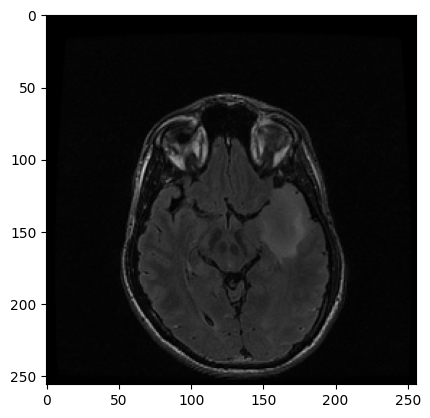

In [127]:
plt.imshow(image)

In [128]:
resized_image = image.resize((224,224))

In [129]:
input_image = np.transpose(resized_image, (2, 0, 1))
input_image = np.expand_dims(input_image, axis=0)
input_image = input_image.astype(np.float32)

In [130]:
results = compiled_model([input_image])

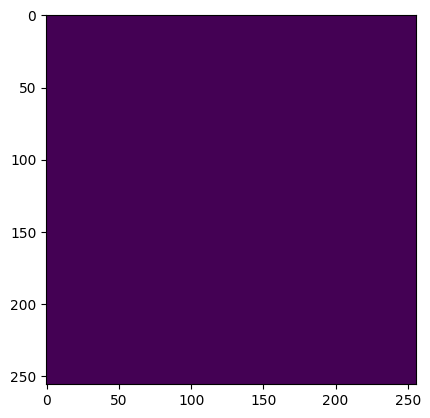

In [131]:
segmentation_mask = np.argmax(results[output_layer], axis=1)[0]
plt.imshow(segmentation_mask)

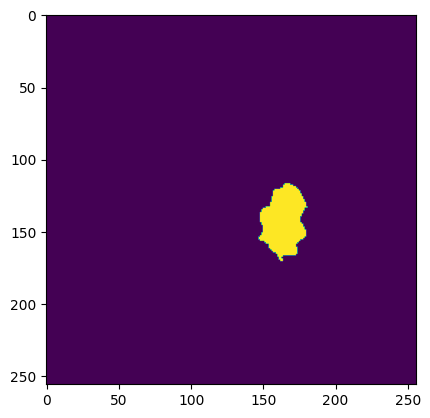

In [133]:
mask = Image.open("./Inference/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_37_mask.tif") #change file name here
plt.imshow(mask)

In [45]:
#imageio.show("Segmenatation mask: ", segmentation_mask)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

## DeeplabV2

In [106]:
import torch.nn.functional as F

In [107]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.aspp1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.aspp2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6, bias=False)
        self.aspp3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12, bias=False)
        self.aspp4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18, bias=False)
        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                             nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                                             nn.Upsample(size=(in_channels, in_channels), mode='bilinear', align_corners=True))

    def forward(self, x):
        x1 = self.aspp1(x)
        # print(f"x1 shape: {x1.shape}")
        x2 = self.aspp2(x)
        # print(f"x2 shape: {x2.shape}")
        x3 = self.aspp3(x)
        # print(f"x3 shape: {x3.shape}")
        x4 = self.aspp4(x)
        # print(f"x4 shape: {x4.shape}")
        x5 = self.global_avg_pool(x)
        # print(f"x5 shape: {x5.shape}")

        # Upsample x5 to match the size of x1, x2, x3, and x4
        target_size = x1.size()[2:]  # Extract the height and width from x1
        x5 = F.interpolate(x5, size=target_size, mode='bilinear', align_corners=True)

        return torch.cat([x1, x2, x3, x4, x5], dim=1)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), # corrected here
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)



class Encoder(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(Encoder, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, mid_channels),
            ASPP(mid_channels, mid_channels),
            nn.Conv2d(mid_channels * 5, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
        )

    def forward(self, x):
        return self.sequence(x)


class Decoder(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, output_size=(256, 256)):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.aspp = ASPP(in_channels, mid_channels)
        self.conv1x1 = nn.Conv2d(mid_channels * 5, out_channels, kernel_size=1, stride=1, padding=0, bias=False)

        self.encoder = Encoder(in_channels, mid_channels, out_channels)
        self.upsample = nn.Upsample(size=self.output_size, mode='bilinear', align_corners=False)

        self.final_conv = nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        x_aspp = self.aspp(x)
        x1 = self.conv1x1(x_aspp)
        x1 = self.upsample(x1)

        x2 = self.encoder(x)
        x2 = self.upsample(x2)

        # Check and adjust the sizes if they do not match
        # if x1.size()[2:] != x2.size()[2:]:
            # Adjust x1 or x2 using additional upsampling or downsampling
            # For example:
            # x1 = F.interpolate(x1, size=x2.size()[2:], mode='bilinear', align_corners=False)

        x_concat = torch.cat([x1, x2], dim=1)
        x_final = self.final_conv(x_concat)
        return x_final


class Deeplab(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(Deeplab, self).__init__()

        # Make sure that the channel sizes are consistent
        self.encoder = Encoder(in_channels, mid_channels, mid_channels)

        # The decoder receives the output from the encoder
        self.decoder = Decoder(mid_channels, mid_channels, out_channels)

    def forward(self, x):
        # Encoder and decoder operations
        x = self.encoder(x)
        x = self.decoder(x)

        return x



In [108]:
def load_checkpoint2(model, filename="Lymhatic_model_18_9_24_Foreground_extraction.pt", dir_add=root_dir):
    filepath = os.path.join(dir_add, filename)
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"No checkpoint found at '{filepath}'")

    checkpoint = torch.load(filepath, torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    best_acc = checkpoint['best_acc']

    print(f"Loaded checkpoint '{filepath}' (epoch {epoch})")

    return model, epoch, best_acc

In [109]:
model2 = Deeplab(in_channels=3, mid_channels=128, out_channels=1)
optimizer2= torch.optim.SGD(model2.parameters(), lr=0.01)
model2, epoch2, best_acc2 = load_checkpoint2(model2, filename="DeepLab.pth", dir_add=root_dir) #remover optimizer2
# model.(torch.load("Segnet.pth", map_location ='cpu')['state_dict'], strict=False)
model2.eval()

Loaded checkpoint './DeepLab.pth' (epoch 0)


Deeplab(
  (encoder): Encoder(
    (sequence): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): ReLU(inplace=True)
          (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (7): ReLU(inplace=True)
        )
      )
      (1): ASPP(
        (aspp1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (aspp2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), bias=False)
        (aspp3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation

In [110]:
dummy_input2 = torch.rand(1, 3, 224, 224)
torch.onnx.export(model2, dummy_input2, "deeplab_model_infer.onnx", verbose=True)



## Unet